### Sliding window of 30 minutes, with data that has been prefiltered with a lowpass of 0.01667 Hz (1 min)

#### Perhaps surpisingly, this didn't work very well. Fits for the temperature and soil moisture datasets are worse than in the case
#### of non-filtered data

In [1]:
import pandas as pd
import obspy as op
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate
import glob
%matplotlib inline

In [2]:
all_data = pd.read_csv("Fnames_soilM_temp.csv")
lineCSN = all_data[all_data['Line'] == "LineCSN"]

#Extract just the soil moisture time series corresponding to probe M3_20
lineCSN_M3 = lineCSN[['file_name','DateTime','M3_20_Avg_interp','Temphigh_interp']]
lineCSN_M3.reset_index(drop=True,inplace=True)
lineCSN_M3.assign(DateTime = pd.to_datetime(lineCSN_M3['DateTime']))
lineCSN_M3.set_index('DateTime',inplace=True)
#Generate linking column
lineCSN_M3 = lineCSN_M3.assign(file_name=lineCSN_M3['file_name'].apply(lambda x: x[2:]))

In [3]:
feature_files = glob.glob('/home/rmartinshort/Documents/Berkeley/Fiber/data_test/Soil_moisture_predict/rms_sliding_30/*.csv')
feature_dfs = []
for csv_file in feature_files:
    fname = csv_file.split('/')[-1].split('.')[0][:-18]
    df = pd.read_csv(csv_file)
    df.name = fname
    feature_dfs.append(df)

In [4]:
lineCSN_M3['TTime'] = lineCSN_M3.index
stime = lineCSN_M3.index[0]
print(op.UTCDateTime(stime))
lineCSN_M3 = lineCSN_M3.assign(tsince_start=lineCSN_M3['TTime'].apply(lambda x: op.UTCDateTime(x) - op.UTCDateTime(stime)))

2016-08-05T18:07:38.000000Z


In [5]:
f_soilM = interpolate.interp1d(lineCSN_M3['tsince_start'].values,lineCSN_M3['M3_20_Avg_interp'].values)
f_temp = interpolate.interp1d(lineCSN_M3['tsince_start'].values,lineCSN_M3['Temphigh_interp'].values)

In [6]:
def extract_mean_over_channels(indf,channels_to_drop):
    
    '''Takes an input dataframe, calculates the mean over columns that are not in the list 
    "channels_to_drop". Returns mean dataframe
    '''
    
    newcolname = "mean_%s" %indf.name
    opdf = indf[['time']]
    opdf = opdf.assign(mean_col = indf.drop(channels_to_drop,axis=1).mean(axis=1))
    opdf.columns = ['time',newcolname]
    
    return opdf

In [7]:
channels_to_drop = ['time']
indf = extract_mean_over_channels(feature_dfs[0],channels_to_drop)

for feature_df in feature_dfs[1:]:
    
    mean_feature = extract_mean_over_channels(feature_df,channels_to_drop)
    merged_df = pd.merge(indf,mean_feature,on='time')
    indf = merged_df

In [8]:
merged_df = merged_df.assign(tsince_start=merged_df['time'].apply(lambda x: op.UTCDateTime(x)-op.UTCDateTime(stime)))  
merged_df = merged_df.assign(M3_20_Avg_interp=merged_df['tsince_start'].apply(lambda x: f_soilM(x)))
merged_df = merged_df.assign(Temphigh_interp=merged_df['tsince_start'].apply(lambda x: f_temp(x)))

In [9]:
cleaned_df = merged_df.dropna()

In [10]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

In [11]:
y = cleaned_df['M3_20_Avg_interp']
X = cleaned_df.drop(['time','tsince_start','M3_20_Avg_interp','Temphigh_interp'],axis=1)

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3)
regr = RandomForestRegressor(n_estimators=300,min_samples_leaf=1,oob_score=True,n_jobs=2)

In [13]:
regr.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=2,
           oob_score=True, random_state=None, verbose=0, warm_start=False)

In [14]:
print(regr.feature_importances_)
print(regr.oob_score_)

[0.09642281 0.04666067 0.08905698 0.01698906 0.07494807 0.08127255
 0.07410688 0.07945054 0.10243694 0.03845115 0.12348457 0.04273954
 0.02473406 0.01545737 0.07777998 0.01600883]
0.4290747577644506


In [15]:
inds = np.argsort(regr.feature_importances_)[::-1]

for i in range(5):
    print(regr.feature_importances_[inds[i]],X.columns[inds[i]])

0.12348457184593595 mean_x_crossing_m_rms_fc
0.10243693619613681 mean_median_rms_fc
0.09642281197258172 mean_mean_rms_fc
0.08905697508348023 mean_peak_welch_rms_fc
0.08127254544800475 mean_interquartile_range_rms_fc


In [16]:
regr.score(X_test,y_test)

0.45725378042412684

In [18]:
regr_pred = regr.predict(X_test)

In [19]:
outliers_y = []
outliers_x = []
X_test_indices = []
i = 0
for element in zip(regr_pred,y_test):
    if abs(element[0]-element[1]) > 0.015:
        outliers_x.append(element[0])
        outliers_y.append(element[1])
        X_test_indices.append(X_test.index[i])
    i += 1

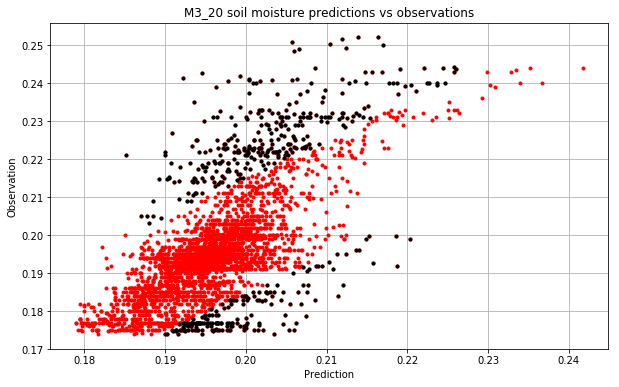

In [20]:
plt.figure(figsize=(10,6))
plt.title('M3_20 soil moisture predictions vs observations')
plt.plot(regr_pred,y_test,'r.')
plt.plot(outliers_x,outliers_y,'k.')
plt.xlabel('Prediction')
plt.ylabel('Observation')
plt.grid()
plt.savefig('soil_moisture_prediction_sliding_window.png')

In [24]:
#x_test_indices is a list containing the indices of the outliers
X_test.loc[X_test_indices].head()

,mean_mean_rms_fc,mean_mean_change_rms_fc,mean_peak_welch_rms_fc,mean_abs_energy_rms_fc,mean_kurtosis_rms_fc,mean_interquartile_range_rms_fc,mean_skewness_rms_fc,mean_minimum_rms_fc,mean_median_rms_fc,mean_mean_abs_change_rms_fc,mean_x_crossing_m_rms_fc,mean_cid_ce_rms_fc,mean_root_mean_square_rms_fc,mean_fft_energy_rms_fc,mean_maximum_rms_fc,mean_variance_rms_fc
6327,-0.061445,-0.000037,9.593750,7.485232e+07,20.927652,17.675927,0.016202,-469.757954,-0.064562,25.378979,36249.5,12235.061763,31.718342,7.485382e+07,487.591092,1039.609015
956,-0.805338,0.000118,9.765625,5.049755e+07,10.443301,18.360414,-0.018218,-340.289443,-0.828756,23.325972,36656.1,10076.247915,26.168098,5.045153e+07,335.224941,700.696406
3152,-0.366855,0.000040,9.796875,2.650760e+07,31.961079,7.739762,0.056126,-295.954239,-0.397155,13.316660,37848.1,7370.750959,18.986146,2.649828e+07,288.689454,368.022159
8088,-0.252988,-0.000288,9.531250,1.290574e+07,37.490566,7.011972,0.074824,-313.516991,-0.225511,9.928800,36751.8,4962.055180,13.250469,1.290143e+07,312.256668,179.181624
6324,-0.235226,-0.001658,10.312500,6.464897e+07,25.318534,18.618547,0.079184,-567.217860,-0.215212,24.280353,35488.8,11344.632968,29.426896,6.464668e+07,665.592813,897.846383


In [33]:
outliers = cleaned_df.loc[X_test_indices]
outlier_x = np.array(outliers['tsince_start'])
outlier_y = np.array(outliers['M3_20_Avg_interp'])
reg_x = np.array(cleaned_df['tsince_start'])
reg_y = np.array(cleaned_df['M3_20_Avg_interp'])

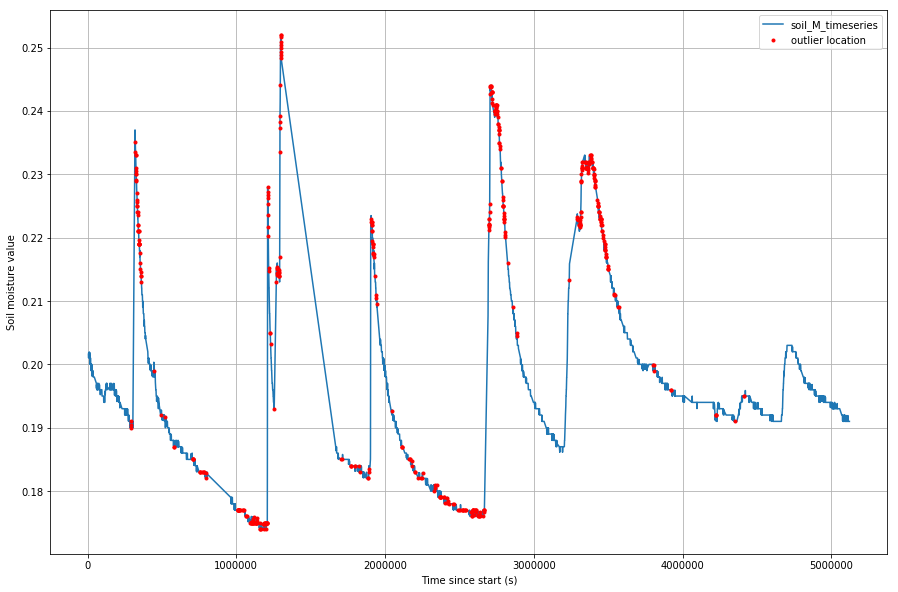

In [44]:
plt.figure(figsize=(15,10))
plt.plot(reg_x,reg_y,label='soil_M_timeseries')
plt.plot(outlier_x,outlier_y,'r.',label='outlier location')
plt.xlabel('Time since start (s)')
plt.ylabel('Soil moisture value')
plt.legend()
plt.grid()

#### As might be expected, most of the outliers are at the peaks or troughs

#### Same proceedure with the temperature dataset

In [45]:
y = cleaned_df['Temphigh_interp']
X = cleaned_df.drop(['time','tsince_start','M3_20_Avg_interp','Temphigh_interp'],axis=1)
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3)
regr = RandomForestRegressor(n_estimators=300,min_samples_leaf=1,oob_score=True,n_jobs=2)
regr.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=2,
           oob_score=True, random_state=None, verbose=0, warm_start=False)

In [46]:
print(regr.feature_importances_)
print(regr.oob_score_)

[0.09611687 0.03229745 0.11216111 0.01264267 0.08136914 0.06618198
 0.05555116 0.05069896 0.10133583 0.03388499 0.23155882 0.02558958
 0.01970367 0.0120669  0.05662747 0.0122134 ]
0.6068700224379032


In [47]:
inds = np.argsort(regr.feature_importances_)[::-1]

for i in range(5):
    print(regr.feature_importances_[inds[i]],X.columns[inds[i]])

0.23155881725759153 mean_x_crossing_m_rms_fc
0.11216111425110405 mean_peak_welch_rms_fc
0.10133582583213882 mean_median_rms_fc
0.09611687142063484 mean_mean_rms_fc
0.08136913860098624 mean_kurtosis_rms_fc


In [48]:
regr.score(X_test,y_test)

0.6159446002387805

In [49]:
regr_pred = regr.predict(X_test)

In [50]:
outliers_y = []
outliers_x = []
X_test_indices = []
i = 0
for element in zip(regr_pred,y_test):
    if abs(element[0]-element[1]) > 4:
        outliers_x.append(element[0])
        outliers_y.append(element[1])
        X_test_indices.append(X_test.index[i])
    i += 1

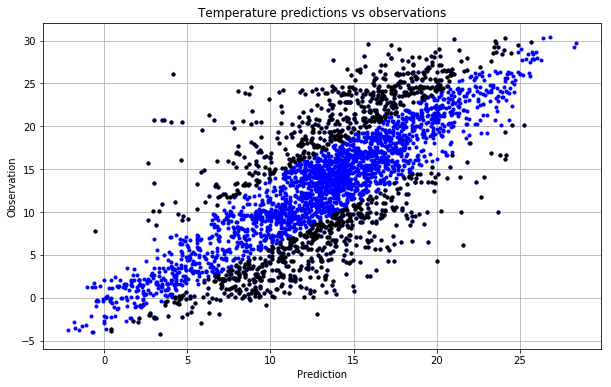

In [51]:
plt.figure(figsize=(10,6))
plt.title('Temperature predictions vs observations')
plt.plot(regr_pred,y_test,'b.')
plt.plot(outliers_x,outliers_y,'k.')
plt.xlabel('Prediction')
plt.ylabel('Observation')
plt.grid()
plt.savefig('temperature_prediction_sliding_window.png')

In [52]:
outliers = cleaned_df.loc[X_test_indices]
outlier_x = np.array(outliers['tsince_start'])
outlier_y = np.array(outliers['Temphigh_interp'])
reg_x = np.array(cleaned_df['tsince_start'])
reg_y = np.array(cleaned_df['Temphigh_interp'])

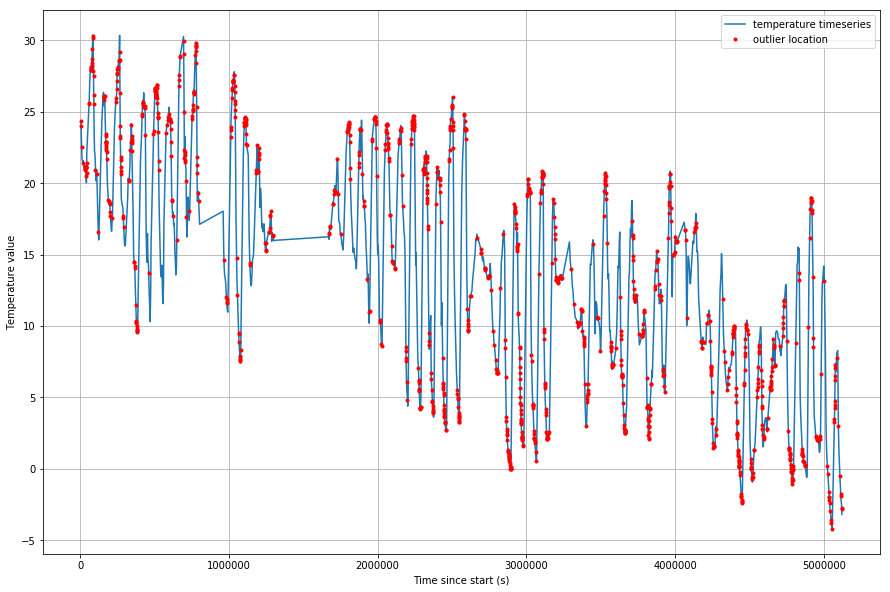

In [53]:
plt.figure(figsize=(15,10))
plt.plot(reg_x,reg_y,label='temperature timeseries')
plt.plot(outlier_x,outlier_y,'r.',label='outlier location')
plt.xlabel('Time since start (s)')
plt.ylabel('Temperature value')
plt.legend()
plt.grid()

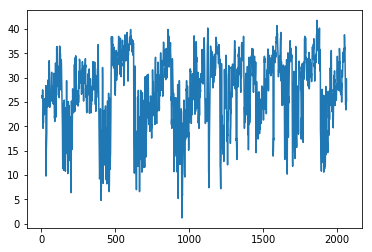

In [50]:
X['mean_x_crossing_m_rms_fc'][:2000].plot()

#### Attempt to understand the gappy nature of this dataset

In [146]:
ser_diff = pd.to_datetime(cleaned_df['time']).diff()

In [147]:
cleaned_df['diffs'] = ser_diff

/home/rmartinshort/anaconda2/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [148]:
step_indices = np.array(cleaned_df[cleaned_df['diffs'] != "00:05:00"].index)

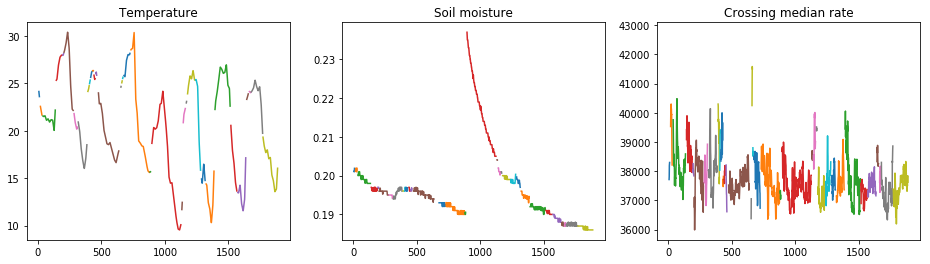

In [154]:
#This is going to break the timeseries into continuous chunks. 
#We might want to filter these chunks individually and then put the the timeseries back together

#We have many small gaps in the data, caused by the despiking filter - could interpolate over thes 
#Large gaps of several hours are more difficult to deal with

fig = plt.figure(figsize=(16,4))
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)

for i in range(len(step_indices)-1):
    start_index = step_indices[i]+1
    end_index = step_indices[i+1]-1
    part_df = cleaned_df.loc[start_index:end_index]
    try:
        part_df['Temphigh_interp'].plot(ax=ax1,title='Temperature')
        part_df['M3_20_Avg_interp'].plot(ax=ax2,title='Soil moisture')
        part_df['mean_x_crossing_m_rms_fc'].plot(ax=ax3,title='Crossing median rate')
    except:
        continue
    if i > 40:
        break

Filering the feature time series when it contains all these gaps seems risky. We can reduce the number of gaps by disabling the despike filter. This might enable us to more reasonably filter the segments and then use them in the prediction stage